-----Reading XML

In [96]:
import xml.etree.ElementTree as ET

In [99]:
tree = ET.parse(r'C:\Users\cid2r\Documents\!VSCode\discogs_20220201_masters.xml')
#tree = ET.parse('rel.xml')
root = tree.getroot()

----Data Scraping

In [3]:
pip install python3-discogs-client

^C
Note: you may need to restart the kernel to use updated packages.


In [100]:
import discogs_client

d = discogs_client.Client('ExampleApplication/0.1', user_token = 'WkcTWMWNFmwUFYHrtQIreHRnLmyFZTNnkflNHsgc')


In [101]:
import os
import urllib.request
from ast import literal_eval

def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise


macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
win_dir = r"D:\AlbumCover"


In [95]:
if 'a' in ['a', 'c'] or 'b' in ['b', 'c']:
    print("no")

no


In [122]:
#0310추가
import requests
import shutil
#0312추가
import requests
from bs4 import BeautifulSoup
import json



for release in root.iter('master'):
    id = release.attrib.get('id')
    
    if int(id) > 164933:


        master_scarp = 'https://www.discogs.com/master/' + str(id)
        soup = BeautifulSoup(requests.get(master_scarp).text)
        rslt = soup.find('script', attrs={'id':'master_schema'})
        if rslt == None:
            continue
        else:
            json_file = json.loads(rslt.get_text())
            rating = json_file['@graph'][0]['aggregateRating']['ratingCount']
            
        standard = 1000 if 'Electronic' in literal_eval(str(json_file['@graph'][0]['genre'])) \
            or 'Rock' in literal_eval(str(json_file['@graph'][0]['genre'])) \
            else 150
    
        if rating >= standard:
            
            print(id)
    
            gens=[]
            for gen in release.iter('genre'):
               gens.append(gen.text)
    
            imglnk = d.master(id).images
            if(imglnk != None):
                if('uri150' in imglnk[0]):
                    uri = imglnk[0]['uri150']
    
        
            if len(gens) == 1:
                if gens[0] == 'Funk / Soul':
                    gens[0] = 'Funk&Soul'
                makedirs(win_dir+gens[0])
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, ('Funk&Soul' if gens[0] == 'Funk / Soul' else gens[0]), img_name)
                #0310add
                makedirs(os.path.join(win_dir, gens[0]))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'})
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
            else:
                multi_dir = ''
                separator = '+'
                for idx, val in enumerate(gens):
                    multi_dir += ('Funk&Soul' if val == 'Funk / Soul' else val) + ('' if idx == len(gens) -1 else separator)
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, 'multi', multi_dir, img_name)
            
                makedirs(os.path.join(win_dir, 'multi',multi_dir))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'})
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
            
            

    
        if int(id) >= 169999:
            break

print("done! done!")



160078
160122
160143
160166
160216
160220
160238
160271
160344
160345
160450
160497
160577
160639
160643
160667
160669
160672
160675
160721
160774
160793
160823
160824
160861
161014
161049
161078
161094
161099
161104
161125
161277
161303
161304
161368
161386
161395
161399
161400
161402
161409
161411
161419
161443
161467
161642
161643
161718
161802
161831
161938
161948
162037
162093
162163
162183
162204
162208
162230
162291
162293
162295
162686
162725
162726
162747
162769
162776
162779
162782
162783
162784
162797
162828
162865
162972
163045
163049
163058
163095
163097
163128
163172
163206
163274
163275
163276
163277
163279
163280
163281
163282
163285
163286
163287
163288
163321
163324
163353
163390
163496
163578
163644
163657
163686
163699
163745
163747
163752
163755
163765
163776
163778
163780
163785
163789
163797
163798
163801
163802
163807
163812
163814
163817
163820
163824
163825
163829
163835
163862
163898
163914
163940
163941
163946
164075
164106
164116
164138
164258
164279
164310

-----현재 안쓰는 코드

In [ ]:
'''
import os

#win
#db_list = os.listdir(r"C:\Users\cid2r\Documents\!VSCode\0220dbtest\data")

#mac
db_list = os.listdir(r"/Users/cooky/Documents/GitHub/0220dbtest/data")
'''

In [ ]:
'''
import pandas as pd


alldata = []

for file in db_list:
    df = pd.read_csv(file)
    alldata.append(df)

df_0_2_100k = pd.concat(alldata, axis=0, ignore_index=True)
df_0_2_100k.to_csv("/Users/cooky/Documents/GitHub/0220dbtest/data/output", index=False)

'''


In [ ]:
df_0_2_100k = pd.read_csv("data_20k_2_25k.csv")

df_test = df_0_2_100k.copy()
df_test.drop(columns='Unnamed: 0')

In [ ]:
from ast import literal_eval


for idx,row in df_test.iterrows():
    gen_str = row['genre']
    gens = literal_eval(gen_str)
    #print(idx)
    for gen in gens:
        if gen in df_test.columns:
            df_test.at[idx, gen] = 1
        else:
            df_test[gen] = 0
            df_test.at[idx, gen] = 1

            

            

In [ ]:
pd.crosstab(df_test.Jazz, df_test.Electronic)

In [ ]:
DISCOGS_KEY = 'OKxXReJmUJvMJRRsaOqr'
DISCOGS_SECRET = 'RormADbxpiujDCXDiBDwFGUFxKrVjkTK'

----실험실

In [1]:
import torch

torch.cuda.is_available()

True

In [48]:
#win
#pip install fastai

#mac
! conda install -c fastai fastai

^C


In [41]:

macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
win_dir = r"D:\AlbumCover"

BATCH_SIZE = 64
IMG_HEI = 150
IMG_WID = 150

In [42]:
import pathlib

dat_dir = pathlib.Path(win_dir)
cnt = len(list(dat_dir.glob('*/*.jpeg')))
print(cnt)

5338


In [43]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image




In [44]:
print(tf.__version__)

2.8.0


In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dat_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEI, IMG_WID),
    batch_size=BATCH_SIZE
)

Found 5338 files belonging to 13 classes.
Using 4271 files for training.


In [46]:
lb = np.concatenate([y for x, y in train_ds], axis = 0)


In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEI, IMG_WID),
  batch_size=BATCH_SIZE)

Found 5338 files belonging to 13 classes.
Using 1067 files for validation.


In [48]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=67>

In [49]:
class_names = train_ds.class_names
print(class_names)

['Blues', 'Classical', 'Electronic', 'Folk, World, & Country', 'Funk&Soul', 'Hip Hop', 'Jazz', 'Latin', 'Non-Music', 'Pop', 'Reggae', 'Rock', 'Stage & Screen']


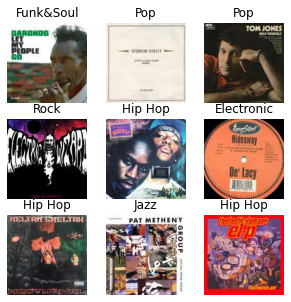

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [20]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(64, 150, 150, 3)
(64,)


In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
lb = np.concatenate([y for x, y in train_ds], axis = 0)

In [22]:
from tensorflow.keras import layers

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [51]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [24]:
num_classes = 14

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEI, IMG_WID, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(196, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='sgd', loss='mse',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

In [18]:
epochs =5


with tf.device("/device:GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

Epoch 1/5
109/109 [==============================] - 7s 28ms/step - loss: 128.4516 - accuracy: 0.1469 - val_loss: 10.7097 - val_accuracy: 0.0017
Epoch 2/5
109/109 [==============================] - 2s 22ms/step - loss: 10.6712 - accuracy: 8.6555e-04 - val_loss: 10.7001 - val_accuracy: 0.5577
Epoch 3/5
109/109 [==============================] - 2s 22ms/step - loss: 10.6631 - accuracy: 0.0349 - val_loss: 10.7358 - val_accuracy: 0.0017
Epoch 4/5
109/109 [==============================] - 2s 22ms/step - loss: 10.6681 - accuracy: 0.0014 - val_loss: 10.7005 - val_accuracy: 0.0035
Epoch 5/5
109/109 [==============================] - 2s 21ms/step - loss: 10.6645 - accuracy: 0.0020 - val_loss: 10.6996 - val_accuracy: 0.0035


In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

KeyError: 'accuracy'

In [107]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEI, 
                                                              IMG_WID,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [118]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight(
    'balanced',np.unique(train_ds.class_names)
    ,train_ds.class_names
)

print(class_weight)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


C:\Users\cid2r\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['Blues' 'Classical' 'Electronic' 'Folk, World, & Country' 'Funk&Soul'
 'Hip Hop' 'Jazz' 'Latin' 'Non-Music' 'Pop' 'Reggae' 'Rock'
 'Stage & Screen' 'models' 'multi'], y=['Blues', 'Classical', 'Electronic', 'Folk, World, & Country', 'Funk&Soul', 'Hip Hop', 'Jazz', 'Latin', 'Non-Music', 'Pop', 'Reggae', 'Rock', 'Stage & Screen', 'models', 'multi'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [72]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(14, activation='sigmoid'))

In [77]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
epochs = 8

with tf.device("/device:GPU:0"):
    history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/8
67/67 [==============================] - 2s 25ms/step - loss: 1.8573 - accuracy: 0.3510 - val_loss: 1.9127 - val_accuracy: 0.3383
Epoch 2/8
67/67 [==============================] - 2s 24ms/step - loss: 1.7427 - accuracy: 0.3971 - val_loss: 1.9244 - val_accuracy: 0.3261
Epoch 3/8
67/67 [==============================] - 2s 23ms/step - loss: 1.5766 - accuracy: 0.4641 - val_loss: 1.9367 - val_accuracy: 0.3477
Epoch 4/8
67/67 [==============================] - 2s 23ms/step - loss: 1.3017 - accuracy: 0.5558 - val_loss: 2.1039 - val_accuracy: 0.3440
Epoch 5/8
67/67 [==============================] - 2s 23ms/step - loss: 1.0212 - accuracy: 0.6525 - val_loss: 2.2802 - val_accuracy: 0.3430
Epoch 6/8
67/67 [==============================] - 2s 23ms/step - loss: 0.7170 - accuracy: 0.7621 - val_loss: 2.7760 - val_accuracy: 0.3308
Epoch 7/8
67/67 [==============================] - 2s 23ms/step - loss: 0.4939 - accuracy: 0.8406 - val_loss: 3.2341 - val_accuracy: 0.3402
Epoch 8/8
67/67 [===

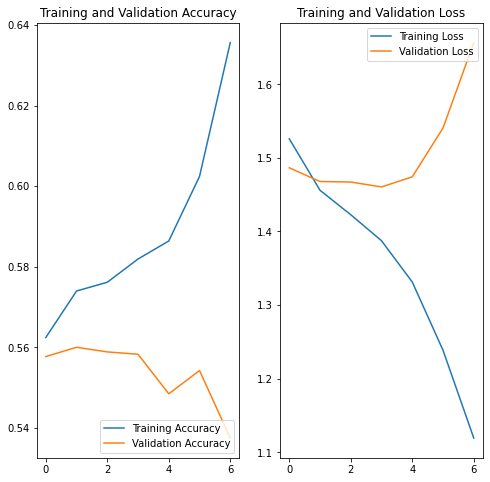

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [82]:
prob = tf.keras.Sequential([model,
                            tf.keras.layers.Softmax()])

pred = prob.predict(val_ds, verbose=2)


type(val_ds)

17/17 - 0s - 435ms/epoch - 26ms/step


tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [83]:
y_train = np.concatenate([y for x, y in val_ds], axis = 0)


In [84]:
np.argmax(pred, axis=1)


array([2, 4, 5, ..., 9, 5, 4], dtype=int64)

In [85]:

#y_train = tf.data.Dataset.from_tensor_slices(list(val_ds))


confusion = tf.math.confusion_matrix(
    labels = y_train,
    predictions=np.argmax(pred, axis=1),
    num_classes=14
)

print(confusion)

tf.Tensor(
[[  0   0   0   0   5   3   0   0   0   2   0   2   0   0]
 [  0   0   4   0   2   2   1   0   0   0   1   0   0   0]
 [  0   0  21   1  26  18   4   0   0   3   3   5   0   0]
 [  0   0   3   0   3   5   3   0   0   1   0   3   0   0]
 [  0   0  43   2 123  56  12   0   0   9  11  10   0   0]
 [  0   0  39   1  58 127  16   0   0   8   3  22   0   0]
 [  1   0  25   1  44  35  28   0   0  16   1  18   0   0]
 [  0   0   0   0   1   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   1   0   0   0   0   1   0   0]
 [  0   0  12   0  20  14   3   0   0   6   3   4   0   0]
 [  0   0   8   0  11  13   5   0   0   4   5   4   0   0]
 [  0   0  14   1  30  30   5   0   0  13   3  13   0   0]
 [  0   0   2   0   1   2   0   0   0   1   1   2   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(14, 14), dtype=int32)


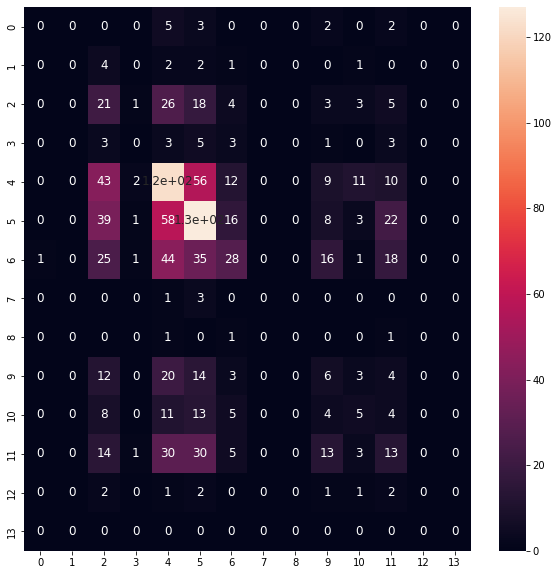

In [86]:
import seaborn as sns
import pandas as pd

cm = pd.DataFrame(confusion.numpy(),
                  range(num_classes),
                  range(num_classes))

plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={'size': 12})
plt.show()

In [92]:
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    print(class_names[i])



Blues
Classical
Electronic
Folk, World, & Country
Funk&Soul
Hip Hop
Jazz
Latin
Non-Music
Pop
Reggae
Rock
Stage & Screen


In [120]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

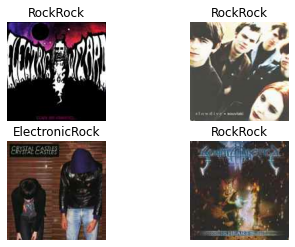

In [129]:
for images, labels in train_ds.take(1):
    for i in range(4):
        ax=plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]] + class_names[np.argmax(pred[i])]
)
        plt.axis('off')
